---

# Probabilistic Forecasting

By: Tomás Urdiales

-> Notebook containing early experiments with quantile regression, as well as notes on handling probabilistic forecasts.

##### Libraries

In [ ]:
# Change notebook CWD to the project's root, so python can read from src:
import os
os.chdir("..")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit

from sklearn.linear_model import LinearRegression, QuantileRegressor

from src import utils
from src.cross_validation import backtesting_CV
from src.join_qh_min_data import join_qh_min_data

##### Parameters

In [3]:
CWD = utils.get_root_dir()

# To not use darts plotting style:
plt.style.use('default')

DPI = 150 # (pixel density for figures)
ELIA_ORANGE = (250/256, 115/256, 1/256) # RGB

##### Load data

In [4]:
qh = utils.load_qh_historical_data().loc["2021":"2022"]
minute = utils.load_min_historical_data().loc["2021":"2022"]
ems = utils.load_ems_historical_data().loc["2021":"2022"]
xb = utils.load_xb_historical_data().loc["2021":"2022"]
temp = utils.load_temp_historical_data().loc["2021":"2022"]

# Additional features:
minute["rolling_15"] = minute["system_imbalance"].rolling(window=15, center=False).mean()
minute["rolling_60"] = minute["system_imbalance"].rolling(window=60, center=False).mean()
# Add in XB data:
qh = qh.assign(xb_day_ahead = xb["xb_day_ahead"])
qh = qh.assign(xb_intraday = xb["xb_intraday"])
qh = qh.assign(xb_grand_total = xb["xb_grand_total"])
qh = qh.assign(xb_physical_accounting_net_import_mw = xb["xb_physical_accounting_net_import_mw"])
# Add in temperature data:
qh = qh.assign(temperature = temp["temperature"])
# Create temperature gradient with respect to one hour ahead:
qh = qh.assign(temperature_diff = -temp["temperature"].diff(-4))

In [23]:
# Quantile loss function:
def quantile_loss(p, difference):
    """
    difference = y - q
    """
    return np.maximum(p*difference, (p-1)*difference)

---

## Legacy quantile regressor

In [38]:
MINUTE = 6
# ! Computation is too slow when using all minutes. We take only the 7th as the next best representation

qh_parameters = {
    "system_imbalance_cum15": {
        "lags": [1]},
    "si_mw": {
        "lags": [-1, -2, -3, -4]},
    "load_id_mw": {
        "lags": [3, 2, 1, 0, -1, -2, -3, -4]},
    "nrv_rt": {
        "lags": [-1, -2, -3, -4]},
}

minute_parameters = {
    "system_imbalance": {
        "lags": [-2, -3]},
    "net_regulation_volume": {
        "lags": [-2, -3]},
}

# Prepare training dataframe:
df = join_qh_min_data(
    qh_data=qh,
    minute_data=minute,
    qh_parameters=qh_parameters,
    minute_parameters=minute_parameters,
    minute=MINUTE,
)
TARGET = "system_imbalance_cum15_from_qh_plus_1"
FEATURES = [feature for feature in df.columns if feature != TARGET]

df = df.dropna()

In [ ]:
# Set up splits and model features:
tscv = TimeSeriesSplit(n_splits=52 * 7 // 7, max_train_size=4 * 24 * 7 * 20, test_size=4 * 24 * 7, gap=0)

In [6]:
# Cross-validation for q-0.95:
results_quantile_p95 = backtesting_CV(model=QuantileRegressor(quantile=0.95, alpha=0.5, solver="highs"),
                                      data=df,
                                      time_splits=tscv,
                                      use_scaler=False,
                                      features=FEATURES,
                                      target=TARGET,
                                      progress_bar=True,
                                      verbose=False,
                                      print_error_metrics=False)

MODEL: QuantileRegressor
Time configuration: 52 splits, 7 testing days, 20 training weeks. Total predicted time: 364 days.



  0%|          | 0/52 [00:00<?, ?it/s]

100%|██████████| 52/52 [04:13<00:00,  4.87s/it]


In [12]:
# Cross-validation for q-0.05:
results_quantile_p05 = backtesting_CV(model=QuantileRegressor(quantile=0.05, alpha=0.5, solver="highs"),
                                      data=df,
                                      time_splits=tscv,
                                      use_scaler=False,
                                      features=FEATURES,
                                      target=TARGET,
                                      progress_bar=True,
                                      verbose=False,
                                      print_error_metrics=False)

MODEL: QuantileRegressor
Time configuration: 52 splits, 7 testing days, 20 training weeks. Total predicted time: 364 days.



100%|██████████| 52/52 [04:13<00:00,  4.88s/it]


In [14]:
# Cross-validation for the mean of the distribution:
results_linear = backtesting_CV(model=LinearRegression(),
                                data=df,
                                time_splits=tscv,
                                use_scaler=False,
                                features=FEATURES,
                                target=TARGET,
                                progress_bar=True,
                                verbose=False,
                                print_error_metrics=False)

MODEL: LinearRegression
Time configuration: 52 splits, 7 testing days, 20 training weeks. Total predicted time: 364 days.



100%|██████████| 52/52 [00:03<00:00, 16.70it/s]


In [49]:
quant_reg = pd.DataFrame(dict(
    mean=results_linear[0]["y_pred"],
    y_test=results_linear[0]["y_test"],
    p05=results_quantile_p05[0]["y_pred"],
    p95=results_quantile_p95[0]["y_pred"])
)

# quant_reg.to_parquet("quantile_legacy.parquet")

89.01% of the prediction intervals contain true target.


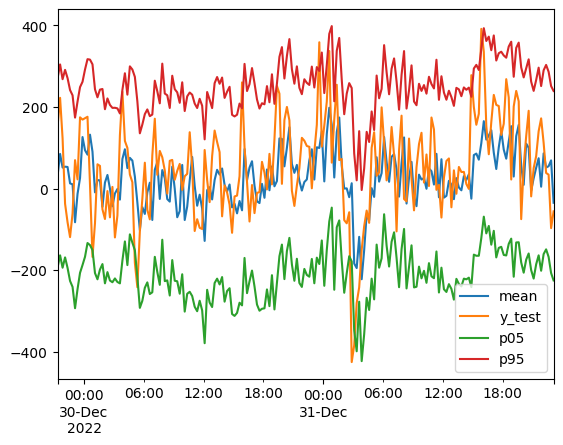

In [50]:
quant_reg.tail(200).plot()

quant_reg_correct = np.mean(
    results_linear[0]["y_test"].between(quant_reg["p05"], quant_reg["p95"])
)
print(f"{quant_reg_correct:.2%} of the prediction intervals contain true target.")

In [51]:
loss_05 = quantile_loss(0.05, results_linear[0]["y_test"] - quant_reg["p05"]).mean()
loss_95 = quantile_loss(0.95, results_linear[0]["y_test"] - quant_reg["p95"]).mean()

print(loss_05, loss_95)

16.997736 16.10783


In [52]:
# Winkler score:
winkler_legacy = (loss_05 + loss_95)/0.1

print(winkler_legacy)

331.05567932128906

---

## New set quantile regressor

In [55]:
MINUTE = 6
# ! Computation is too slow when using all minutes. We take only the 7th as the next best representation

qh_parameters = {
    "system_imbalance_cum15": {
        "lags": [1, -1, -2, -3, -4, -5, 
        -95, -94, -93, -96,
        # -191, -190, -189, -192,
        # -287, -286, -285, -288,
        # -383, -382, -381, -384,
        # -479, -478, -477, -480,
        # -575, -574, -573, -576,
        -671, -670, -669, -672,
        -17, -21, -23]},

    "xb_grand_total": {
        "lags": [4, 1, 0, -4]},

    "total_load_last_mw": {
        "lags": [3, -3]},
    "nrv_rt": {
        "lags": [-1, -2, -3, -4]},
    "load_rt_mw": {
        "lags": [-3]},
    "wind_rt_mw": {
        "lags": [-1, -3]},

    "temperature_diff": {
    "lags": [4, 0]},
}

minute_parameters = {
    "system_imbalance": {
        "lags": [-2, -181, -18, -33, -64, -63]},

    "net_regulation_volume": {
        "lags": [-2]},
}

# Prepare training dataframe:
df = join_qh_min_data(
    qh_data=qh,
    minute_data=minute,
    qh_parameters=qh_parameters,
    minute_parameters=minute_parameters,
    minute=MINUTE,
)
TARGET = "system_imbalance_cum15_from_qh_plus_1"
FEATURES = [feature for feature in df.columns if feature != TARGET]

df = df.dropna()

In [57]:
# Set up splits and model features:
tscv = TimeSeriesSplit(n_splits=52 * 7 // 7, max_train_size=4 * 24 * 7 * 20, test_size=4 * 24 * 7, gap=0)

In [58]:
# Cross-validation for q-0.95:
results_quantile_p95 = backtesting_CV(model=QuantileRegressor(quantile=0.95, alpha=0.5, solver="highs"),
                                      data=df,
                                      time_splits=tscv,
                                      use_scaler=False,
                                      features=FEATURES,
                                      target=TARGET,
                                      progress_bar=True,
                                      verbose=False,
                                      print_error_metrics=False)

MODEL: QuantileRegressor
Time configuration: 52 splits, 7 testing days, 20 training weeks. Total predicted time: 364 days.



100%|██████████| 52/52 [06:37<00:00,  7.64s/it]


In [59]:
# Cross-validation for q-0.05:
results_quantile_p05 = backtesting_CV(model=QuantileRegressor(quantile=0.05, alpha=0.5, solver="highs"),
                                      data=df,
                                      time_splits=tscv,
                                      use_scaler=False,
                                      features=FEATURES,
                                      target=TARGET,
                                      progress_bar=True,
                                      verbose=False,
                                      print_error_metrics=False)

MODEL: QuantileRegressor
Time configuration: 52 splits, 7 testing days, 20 training weeks. Total predicted time: 364 days.



100%|██████████| 52/52 [06:37<00:00,  7.65s/it]


In [60]:
# Cross-validation for the mean of the distribution:
results_linear = backtesting_CV(model=LinearRegression(),
                                data=df,
                                time_splits=tscv,
                                use_scaler=False,
                                features=FEATURES,
                                target=TARGET,
                                progress_bar=True,
                                verbose=False,
                                print_error_metrics=False)

MODEL: LinearRegression
Time configuration: 52 splits, 7 testing days, 20 training weeks. Total predicted time: 364 days.



100%|██████████| 52/52 [00:16<00:00,  3.15it/s]


In [61]:
quant_reg = pd.DataFrame(dict(
    mean=results_linear[0]["y_pred"],
    p05=results_quantile_p05[0]["y_pred"],
    p95=results_quantile_p95[0]["y_pred"])
)

In [62]:
quant_reg.to_parquet("quantile_new.parquet")

89.06% of the prediction intervals contain true target.


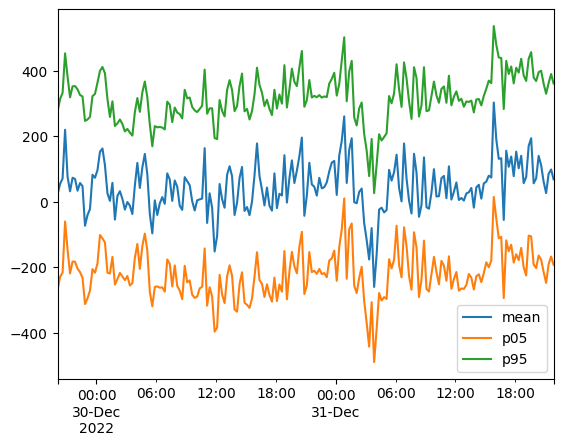

In [63]:
quant_reg.tail(200).plot()

quant_reg_correct = np.mean(
    results_linear[0]["y_test"].between(quant_reg["p05"], quant_reg["p95"])
)
print(f"{quant_reg_correct:.2%} of the prediction intervals contain true target.")

In [ ]:
loss_05 = quantile_loss(0.05, results_linear[0]["y_test"] - quant_reg["p05"]).mean()
loss_95 = quantile_loss(0.95, results_linear[0]["y_test"] - quant_reg["p95"]).mean()

print(loss_05, loss_95)

16.997736 16.10783


In [64]:
loss_05 = quantile_loss(0.05, results_linear[0]["y_test"] - quant_reg["p05"]).mean()
loss_95 = quantile_loss(0.95, results_linear[0]["y_test"] - quant_reg["p95"]).mean()

print(loss_05, loss_95)

15.852943 15.108719


In [68]:
# Winkler score:
winkler_new = (loss_05 + loss_95)/0.1
print(winkler_new)

309.6166229248047


In [71]:
100*(1-winkler_new/331.05567932128906)

6.475966955298118

---

## Using statsmodels

In [7]:
from scipy.stats import t
import statsmodels.api as sm

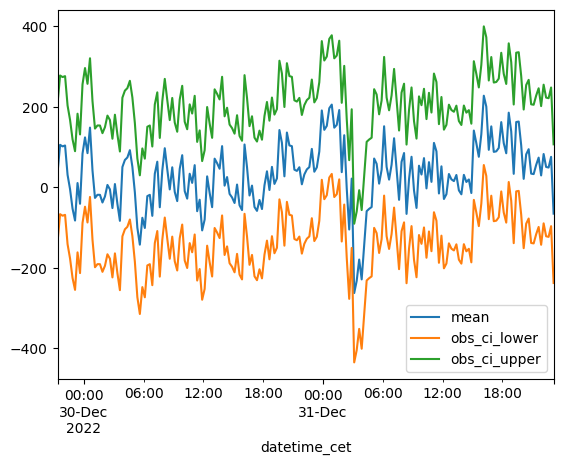

In [8]:
# Ordinary Least Squares through statsmodels:
ols = sm.OLS(df[TARGET], sm.add_constant(df[FEATURES])).fit()

ols = (ols
    .get_prediction(sm.add_constant(df[FEATURES]))
    .summary_frame(alpha=0.2)[['mean', 'obs_ci_lower', 'obs_ci_upper']])

ols.tail(200).plot()
plt.show()

In [9]:
ols_correct = np.mean(
    df[TARGET].between(ols['obs_ci_lower'], ols['obs_ci_upper'])
)
print(f"{ols_correct:.2%} of the prediction intervals contain true target.")

83.38% of the prediction intervals contain true target.


---

## Comparison


In [10]:
quant_reg

,mean,p10,p90
2022-01-01 17:38:00+01:00,-58.473602,-195.168701,99.157410
2022-01-01 17:53:00+01:00,11.608948,-139.271667,144.557114
2022-01-01 18:08:00+01:00,-57.813530,-190.715759,92.159370
2022-01-01 18:23:00+01:00,-54.013069,-200.741272,87.930565
2022-01-01 18:38:00+01:00,-56.284264,-182.098251,108.667770
...,...,...,...
2022-12-31 22:08:00+01:00,86.379990,-64.885345,225.148621
2022-12-31 22:23:00+01:00,69.789337,-63.568405,226.880447
2022-12-31 22:38:00+01:00,60.002712,-89.081314,200.565399
2022-12-31 22:53:00+01:00,75.188248,-114.373398,188.068634


In [11]:
ols

,mean,obs_ci_lower,obs_ci_upper
datetime_cet,,,
2021-01-01 01:08:00+01:00,-10.671099,-182.851637,161.509438
2021-01-01 01:23:00+01:00,51.943949,-120.239022,224.126919
2021-01-01 01:38:00+01:00,133.763160,-38.422082,305.948402
2021-01-01 01:53:00+01:00,83.941587,-88.242322,256.125496
2021-01-01 02:08:00+01:00,58.958352,-113.226162,231.142865
...,...,...,...
2022-12-31 22:08:00+01:00,82.566275,-89.623957,254.756507
2022-12-31 22:23:00+01:00,50.465749,-121.725110,222.656608
2022-12-31 22:38:00+01:00,48.975332,-123.221221,221.171885
